# PIERS Data Cleaning

This notebook addresses missing data and other issues in the PIERS BOL data. This work is predominantly exploratory in nature, and some of these processes may eventually move to the ETL step. 

In [1]:
import pandas as pd
import polars as pl
import plotly_express as px
import missingno as msno

#display settings
pd.set_option('display.max_columns', None)

#enable string cache for polars categoricals
pl.enable_string_cache()

Convenience steps:
- create 2-digit hs codes (note this naievely takes the first two digits from the column, which contains multiple hs codes)
- create year and month (e.g., 202305) columns 
- replace zero values with nulls in volume columns

In [2]:
#set paths
imports_path = 'data/clean/imports/'
exports_path = 'data/clean/exports/'
#init lazy dataframes
imports_lf = (
    pl.scan_parquet(imports_path+'*.parquet', parallel='columns')
    .with_columns([
        #create 2-digit hs code
        pl.col('hs_code').str.slice(0, length=2).alias('hs_2d'),
        #create year and month columns
        pl.col('date_arrival').dt.year().alias('year'),
        pl.col('date_arrival').dt.strftime('%Y%m').alias('month'),
        #convert zero volume values to null
        pl.col('teus').replace(0,None),
        pl.col('weight').replace(0,None),
        pl.col('qty').replace(0,None)
        ])
    )
exports_lf = (
    pl.scan_parquet(exports_path+'piers_exports_complete.parquet', parallel='columns')
    .with_columns([
        #create 2-digit hs code
        pl.col('hs_code').str.slice(0, length=2).alias('hs_2d'),
        #create year and month columns
        pl.col('date_departure').dt.year().alias('year'),
        pl.col('date_departure').dt.strftime('%Y%m').alias('month'),
        #convert zero volume values to null
        pl.col('teus').replace(0,None),
        pl.col('weight').replace(0,None),
        pl.col('qty').replace(0,None)
        ])
    )

#unify dataframes
imports_lf = imports_lf.with_columns(pl.lit('import').alias('direction'))
exports_lf = exports_lf.with_columns(pl.lit('export').alias('direction'))
piers_lf = pl.concat([imports_lf, exports_lf])

## Missing Data


Missing Values Matrix for Exports. 
The vertical axis corresponds to date, with earliest at the top.  
Note the daily aggregation counts the row as non-null if any value that day is non-null.


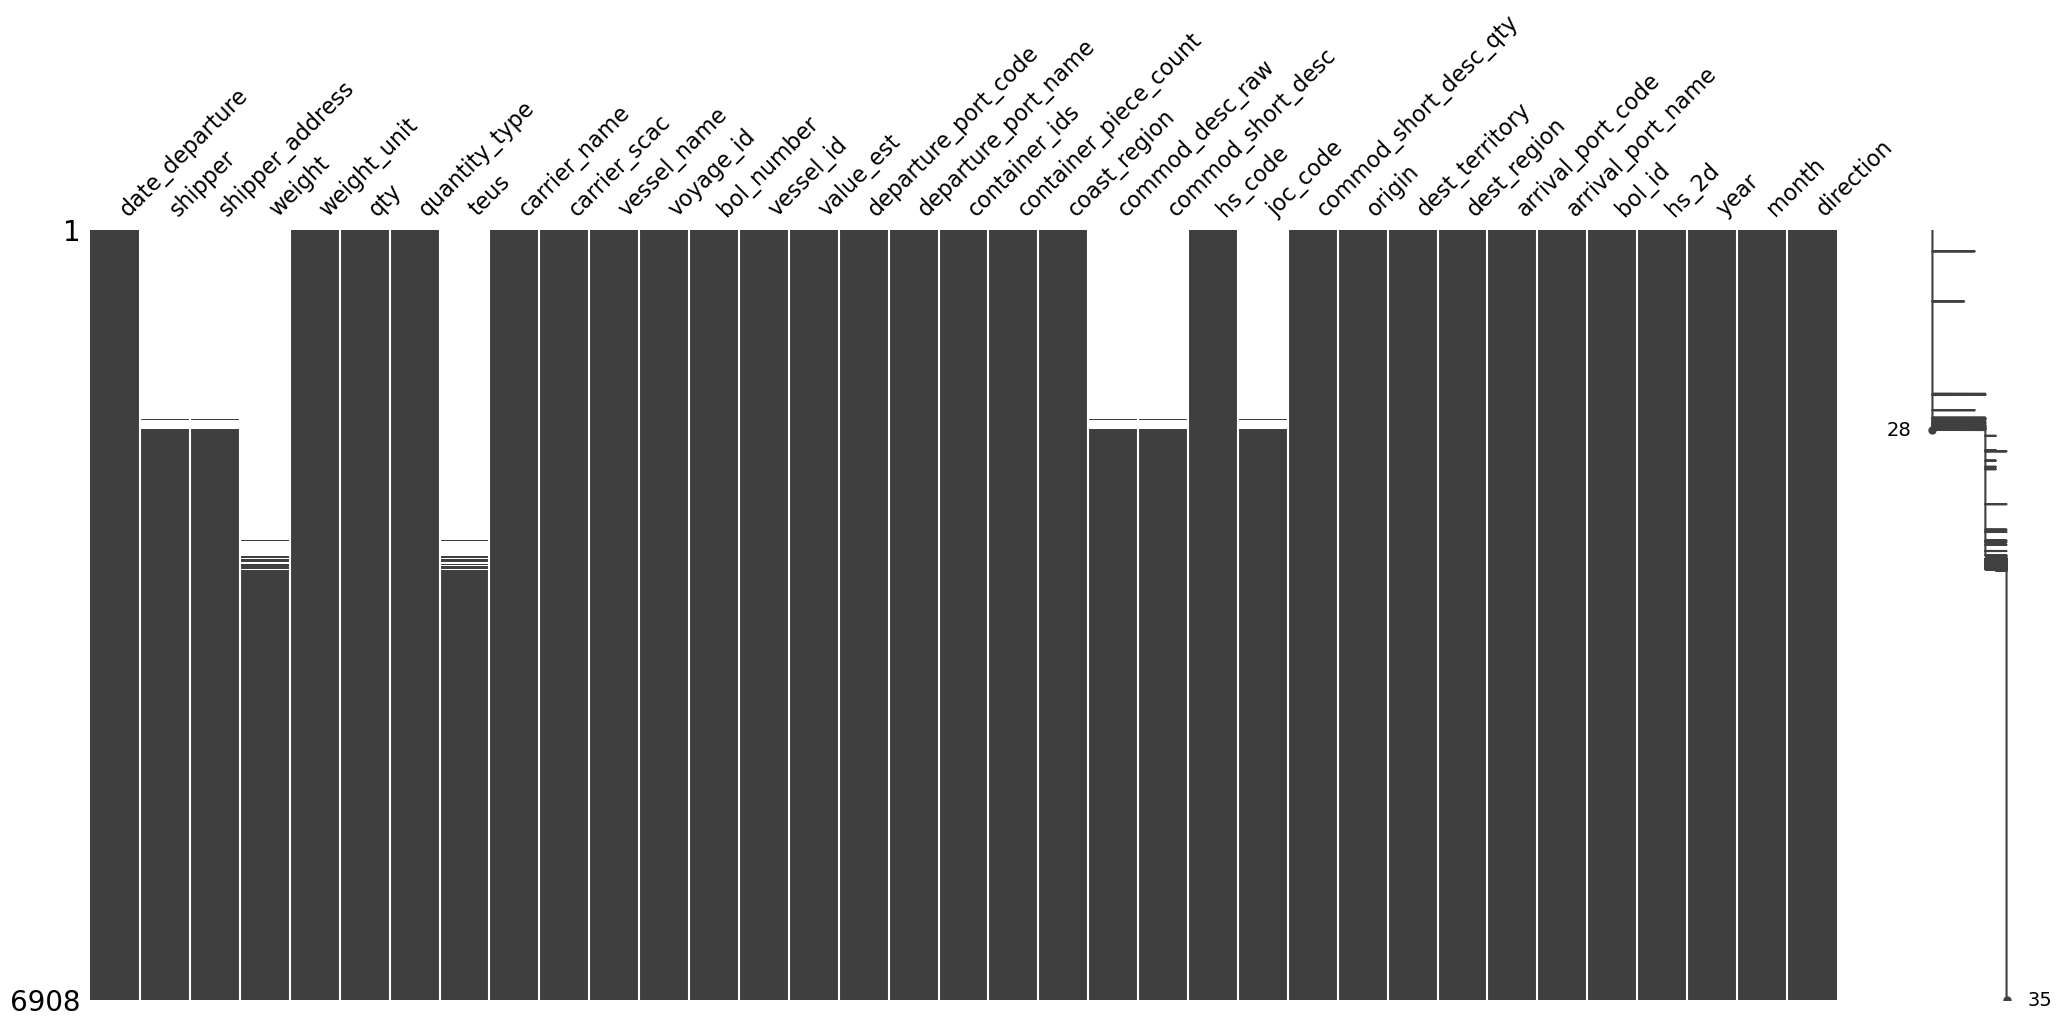

In [3]:
print('Missing Values Matrix for Exports. \nThe vertical axis corresponds to date, with earliest at the top.  \nNote the daily aggregation counts the row as non-null if any value that day is non-null.')
msno.matrix(
    exports_lf
    #convert all columns except date to boolean False=null
    .with_columns(pl.all().exclude('date_departure').is_not_null())
    #aggregate by day to stay within visualization limitations 
    .group_by('date_departure').sum()
    .sort('date_departure')
    #convert False values back to null 
    .with_columns(pl.all().replace(0,None))
    .collect()
    .to_pandas()
    );

In [4]:
print('Missing Values Matrix for Imports. \nThe vertical axis corresponds to date, with earliest at the top. \nNote the daily aggregation counts the row as non-null if any value that day is non-null.')
msno.matrix(
    imports_lf
    #convert all columns except date to boolean False=null
    .with_columns(pl.all().exclude('date_arrival').is_not_null())
    #aggregate by day to stay within visualization limitations 
    .group_by('date_arrival').sum()
    .sort('date_arrival')
    #convert False values back to null 
    .with_columns(pl.all().replace(0,None))
    .collect()
    .to_pandas()
    );

Missing Values Matrix for Imports. 
The vertical axis corresponds to date, with earliest at the top. 
Note the daily aggregation counts the row as non-null if any value that day is non-null.


### Zero values in TEU and other volume columns

For the time being, we fill the zero (i.e., missing) volume data with the mean from non-zero observations. This step is expected to change as beter metadata is gathered. 

In [ ]:
piers_lf = (
    piers_lf
    .with_columns([
        pl.col('teus').replace(0,None).fill_null(strategy='mean'),
        pl.col('weight').replace(0,None).fill_null(strategy='mean'),
        pl.col('qty').replace(0,None).fill_null(strategy='mean')
        ])
    )

### Missing Vessel and Voyage IDs

Identifying unique vessels and voyages is critical to studying how long each vessel remains in port, how often carriers utilize alliances (e.g., what proportion of a vessel's cargo is from another carrier), and other quality metrics. 

In [ ]:
def nulls_over_time_plotly(data_lf, group_var, time_var, value_var, title=False):
    #groupby
    lf = (
        data_lf.select([group_var, time_var, value_var])
        .group_by(group_var, time_var)
        .agg([pl.col(value_var).null_count().alias('null_count'),
                pl.col(value_var).count().alias('count')])
        .with_columns((pl.col('null_count')/(pl.col('count')+pl.col('null_count'))).alias('null_percent'))
        .sort(time_var)
    )
    #plot
    fig = px.line(
        data_frame=lf.collect(),
        x=time_var, y='null_percent',
        color=group_var,
        title= 'Count of nulls over time by source frame.' if not title else title
    )
    fig.show()

In [ ]:
nulls_over_time_plotly(
    data_lf=piers_lf,
    group_var='direction',
    time_var='month',
    value_var='voyage_id',
    title='Proportion of Missing Voyage IDs over time.'
)

In [ ]:
nulls_over_time_plotly(
    data_lfs=[imports_lf,exports_lf],
    lfs_aliases=['imports', 'exports'],
    time_var='month',
    value_var='vessel_id',
    title='Proportion of Missing Vessel IDs over time.'
)

In [ ]:
nulls_over_time_plotly(
    data_lf=piers_lf,
    group_var='direction',
    time_var='month',
    value_var='arrival_port_code',
    title='Proportion of Missing arrival port codes over time.'
)

## Export Clean data to parquet


In [ ]:
#piers_lf.collect().write_parquet('data/piers_clean.parquet')